In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
%matplotlib inline
from cbrain.imports import *
from cbrain.utils import *
from cbrain.data_generator import DataGenerator, threadsafe_generator
from cbrain.models import *
from cbrain.model_diagnostics import ModelDiagnostics
limit_mem()

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
PREPROC_DIR = '/scratch/srasp/preprocessed_data/'

In [36]:
norms = ('feature_means', 'max_rs', None, 'target_conv')

In [17]:
def get_lr_sched(lr_init, div, step):
    def lr_update(epoch):
        # From goo.gl/GXQaK6
        init_lr = lr_init
        drop = 1./div
        epochs_drop = step
        lr = init_lr * np.power(drop, np.floor((1+epoch)/epochs_drop))
        print('lr:', lr)
        return lr
    return lr_update

In [141]:
def get_diag(m, sst='4k', convo=False, convo_tile=False):
    return ModelDiagnostics(m, 
                    fpath=f'{PREPROC_DIR}fbp_engy_ess_valid_{sst}_features.nc',
                    tpath=f'{PREPROC_DIR}fbp_engy_ess_valid_{sst}_targets.nc',
                    npath=f'{PREPROC_DIR}fbp_engy_ess_train_fullyear_norm.nc',
                    norms=norms, convo=convo, convo_tile=convo_tile)

In [142]:
def evaluate(m, convo=False, convo_tile=False):
    dref = get_diag(m, 'fullyear', convo, convo_tile); dref.compute_stats()
    print(dref.mean_stats(10)['hor_r2'])
    d4k = get_diag(m, '4k', convo, convo_tile); d4k.compute_stats()
    print(d4k.mean_stats(10)['hor_r2'])
    d4k.plot_double_yz(10, 15, 'TPHYSTND', cmap='bwr', vmin=-7e-4, vmax=7e-4);
    return dref, d4k

## Load trained model and test on +4K data

In [31]:
mref = keras.models.load_model(
    '/export/home/srasp/repositories/CBRAIN-CAM/saved_models/D004_fbp_engy_ess_fullyear_max_rs_deep.h5')

In [49]:
dref_ref = get_diag(mref, 'fullyear')

In [51]:
dref_ref.compute_stats()

100%|██████████| 2868/2868 [02:04<00:00, 23.13it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['true_var'] = tsqsum / nt - tmean ** 2
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: invalid value encountered in true_divide
  self.stats['true_var'] = tsqsum / nt - tmean ** 2
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:255: RuntimeWarning: invalid value encountered in true_divide
  self.stats['hor_tvar'] = self.stats['hor_tsqmean'] - self.stats['hor_tmean'] ** 2


In [52]:
dref_ref.mean_stats(10)

,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
TPHYSTND,-9.14599e-08,1.35139e-09,-8.03612e-08,1.10986e-08,1.87124e-09,3.24716e-09,1.72423e-09,3.09587e-09,0.477943,3.24716e-09,1.10986e-08,1.35139e-09,3.22749e-09,0.580055
PHQ,5.8666e-11,1.75085e-15,1.16132e-09,1.10265e-09,8.52659e-16,2.59918e-15,7.97542e-16,2.54498e-15,-5.78812,2.59918e-15,1.10265e-09,1.75085e-15,2.58763e-15,0.52887
FSNT,0.243747,662.97,231.641,231.397,159760,160087,84168.7,84664.5,-inf,160087,231.397,662.97,106542,0.993777
FSNS,0.29577,823.27,164.731,164.436,89654.1,90197.6,50174,50864.6,-inf,90197.6,164.436,823.27,63158.5,0.986965
FLNT,-0.091458,118.23,222.857,222.949,51672.2,51826.7,1212.98,1325.63,0.884928,51826.7,222.949,118.23,2120.53,0.944245
FLNS,0.125536,80.1337,52.8188,52.6932,3471.2,3534.84,546.276,623.33,0.85212,3534.84,52.6932,80.1337,758.261,0.894319
PRECT,-1.89456e-10,1.3206e-15,3.07286e-08,3.09181e-08,1.17894e-14,1.32245e-14,9.59229e-15,1.10006e-14,0.713573,1.32245e-14,3.09181e-08,1.3206e-15,1.22686e-14,0.892359
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.831513


In [59]:
dref_4k = get_diag(mref, '4k'); dref_4k.compute_stats()

100%|██████████| 287/287 [00:11<00:00, 25.90it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: invalid value encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:255: RuntimeWarning: invalid value encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [60]:
dref_4k.mean_stats(10)

,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
TPHYSTND,1.55228e-05,6.56728e-09,1.51985e-05,-3.24351e-07,1.07533e-08,4.40622e-09,6.28847e-09,3.7536e-09,-2.07075,4.40622e-09,-3.24351e-07,6.56728e-09,4.38594e-09,-1.12919
PHQ,-9.71356e-09,5.54693e-15,-8.37438e-09,1.33919e-09,4.78158e-15,3.76454e-15,2.76725e-15,3.56827e-15,-14.9746,3.76454e-15,1.33919e-09,5.54693e-15,3.7438e-15,-0.947225
FSNT,-15.2356,4587.73,206.671,221.906,130338,151176,68751.8,81190.3,-inf,151176,221.906,4587.73,101933,0.954993
FSNS,-14.1967,4523.82,136.323,150.519,66236.5,80111.1,37424.3,46146.2,-inf,80111.1,150.519,4523.82,57455,0.921263
FLNT,-18.4487,2500.01,213.167,231.616,49988.6,56040.8,2842,1136.28,-4.29241,56040.8,231.616,2500.01,2394.94,-0.0438734
FLNS,-2.27457,157.619,41.3582,43.6328,2293.63,2581.83,338.205,422.6,-0.372877,2581.83,43.6328,157.619,678.012,0.767528
PRECT,3.05769e-08,1.87298e-14,6.75167e-08,3.69398e-08,6.1274e-14,2.19591e-14,3.19316e-14,1.51478e-14,-11.4518,2.19591e-14,3.69398e-08,1.87298e-14,2.05945e-14,0.0905449
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0877204


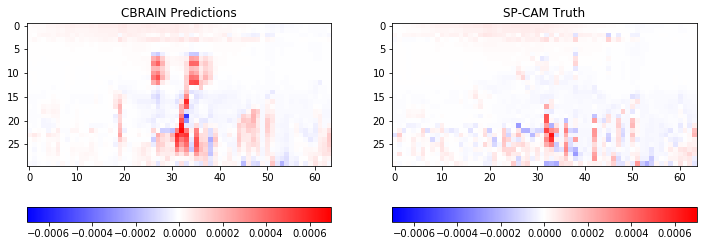

In [70]:
dref_4k.plot_double_yz(10, 15, 'TPHYSTND', cmap='bwr', vmin=-7e-4, vmax=7e-4);

## Train new models

### Standard model

In [71]:
train_gen = DataGenerator(
    PREPROC_DIR,
    'fbp_engy_ess_train_sample1_shuffle_features.nc',
    'fbp_engy_ess_train_sample1_shuffle_targets.nc',
    1024,
    'fbp_engy_ess_train_fullyear_norm.nc',
    'feature_means', 'max_rs', None, 'target_conv',
    shuffle=True,
)

Generator will have 23494656 samples in 22944 batches
Features have shape 94; targets have shape 65


In [72]:
mstd = fc_model(
    94,
    65,
    [256,256,256,256,256,256,256,256,256],
    1e-2,
    'mse',
    batch_norm=False,
    activation='LeakyReLU',
    dr=None,
    l2=None,
)

In [73]:
mstd.fit_generator(
    train_gen.return_generator(),
    train_gen.n_batches/5,
    epochs=3,
    workers=8,
    max_queue_size=50,
    callbacks=[LearningRateScheduler(get_lr_sched(1e-2, 5, 1))],
)

Epoch 1/3
lr: 0.002
4589/4588 [==============================] - 151s 33ms/step - loss: 0.0062 - rmse: 0.0578 - log_loss: -1.3817 - var_ratio: 0.5157 - mean_squared_error: 0.0062 - var_loss: 3.8994e-05s - loss: 0.0062 - rmse: 0.0579 - log_loss: -1.38 - ETA: 0s - loss: 0.0062 - rmse: 0.0578 - log_loss: -1.3816 - var_ratio: 0.5155 - mean_squared_error: 0
Epoch 2/3
lr: 0.0004000000000000001
4589/4588 [==============================] - 144s 31ms/step - loss: 0.0056 - rmse: 0.0543 - log_loss: -1.4166 - var_ratio: 0.5638 - mean_squared_error: 0.0056 - var_loss: 3.1465e-05
Epoch 3/3
lr: 8.000000000000002e-05
4589/4588 [==============================] - 137s 30ms/step - loss: 0.0054 - rmse: 0.0532 - log_loss: -1.4281 - var_ratio: 0.5781 - mean_squared_error: 0.0054 - var_loss: 2.9362e-05- ETA: 4s - loss: 0.0054 - rmse: 0.0532 - log_loss: -1.4280 - var_ratio: 0.5779 - mean_squa - ETA: 3s - loss: 0.0054 - rmse: 0.05


In [74]:
dstd_ref = get_diag(mstd, 'fullyear'); dstd_ref.compute_stats()

100%|██████████| 2868/2868 [01:54<00:00, 24.97it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:255: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


In [75]:
dstd_ref.mean_stats(10)

,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
TPHYSTND,-2.28254e-07,1.61335e-09,-2.17155e-07,1.10986e-08,1.5766e-09,3.24716e-09,1.43653e-09,3.09587e-09,0.330048,3.24716e-09,1.10986e-08,1.61335e-09,3.22749e-09,0.480776
PHQ,5.18572e-11,1.93549e-15,1.15451e-09,1.10265e-09,6.55248e-16,2.59918e-15,5.94798e-16,2.54498e-15,-18.8534,2.59918e-15,1.10265e-09,1.93549e-15,2.58763e-15,0.451516
FSNT,-3.48384,1107.79,227.913,231.397,155375,160087,82171.9,84664.5,-inf,160087,231.397,1107.79,106542,0.989602
FSNS,-2.88879,1288.4,161.547,164.436,86680,90197.6,48663.6,50864.6,-inf,90197.6,164.436,1288.4,63158.5,0.9796
FLNT,-1.26484,258.89,221.684,222.949,51060,51826.7,1131.81,1325.63,0.755512,51826.7,222.949,258.89,2120.53,0.877913
FLNS,-0.0470142,129.435,52.6462,52.6932,3416.02,3534.84,512.986,623.33,0.762219,3534.84,52.6932,129.435,758.261,0.8293
PRECT,-6.37913e-10,1.64044e-15,3.02802e-08,3.09181e-08,1.09459e-14,1.32245e-14,8.83651e-15,1.10006e-14,0.640418,1.32245e-14,3.09181e-08,1.64044e-15,1.22686e-14,0.866289
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.782142


In [76]:
dstd_4k = get_diag(mref, '4k'); dstd_4k.compute_stats(); dstd_4k.mean_stats(10)

100%|██████████| 287/287 [00:11<00:00, 25.05it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: invalid value encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:255: RuntimeWarning: invalid value encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
TPHYSTND,1.55228e-05,6.56728e-09,1.51985e-05,-3.24351e-07,1.07533e-08,4.40622e-09,6.28847e-09,3.7536e-09,-2.07075,4.40622e-09,-3.24351e-07,6.56728e-09,4.38594e-09,-1.12919
PHQ,-9.71356e-09,5.54693e-15,-8.37438e-09,1.33919e-09,4.78158e-15,3.76454e-15,2.76725e-15,3.56827e-15,-14.9746,3.76454e-15,1.33919e-09,5.54693e-15,3.7438e-15,-0.947225
FSNT,-15.2356,4587.73,206.671,221.906,130338,151176,68751.8,81190.3,-inf,151176,221.906,4587.73,101933,0.954993
FSNS,-14.1967,4523.82,136.323,150.519,66236.5,80111.1,37424.3,46146.2,-inf,80111.1,150.519,4523.82,57455,0.921263
FLNT,-18.4487,2500.01,213.167,231.616,49988.6,56040.8,2842,1136.28,-4.29241,56040.8,231.616,2500.01,2394.94,-0.0438734
FLNS,-2.27457,157.619,41.3582,43.6328,2293.63,2581.83,338.205,422.6,-0.372877,2581.83,43.6328,157.619,678.012,0.767528
PRECT,3.05769e-08,1.87298e-14,6.75167e-08,3.69398e-08,6.1274e-14,2.19591e-14,3.19316e-14,1.51478e-14,-11.4518,2.19591e-14,3.69398e-08,1.87298e-14,2.05945e-14,0.0905449
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0877204


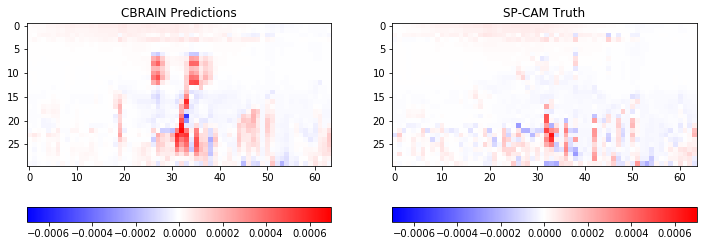

In [77]:
dstd_4k.plot_double_yz(10, 15, 'TPHYSTND', cmap='bwr', vmin=-7e-4, vmax=7e-4);

### Batch norm

In [78]:
mbn = fc_model(
    94,
    65,
    [256,256,256,256,256,256,256,256,256],
    1e-2,
    'mse',
    batch_norm=True,
    activation='LeakyReLU',
    dr=None,
    l2=None,
)

In [80]:
mbn.fit_generator(
    train_gen.return_generator(),
    train_gen.n_batches/5,
    epochs=3,
    workers=8,
    max_queue_size=50,
    callbacks=[LearningRateScheduler(get_lr_sched(1e-2, 5, 1))],
)

Epoch 1/3
lr: 0.002
4589/4588 [==============================] - 250s 54ms/step - loss: 0.0078 - rmse: 0.0647 - log_loss: -1.3019 - var_ratio: 0.6210 - mean_squared_error: 0.0078 - var_loss: 9.6638e-04
Epoch 2/3
lr: 0.0004000000000000001
4589/4588 [==============================] - 248s 54ms/step - loss: 0.0057 - rmse: 0.0559 - log_loss: -1.3875 - var_ratio: 0.5657 - mean_squared_error: 0.0057 - var_loss: 3.1468e-05
Epoch 3/3
lr: 8.000000000000002e-05
4589/4588 [==============================] - 249s 54ms/step - loss: 0.0055 - rmse: 0.0543 - log_loss: -1.4082 - var_ratio: 0.5752 - mean_squared_error: 0.0055 - var_loss: 3.0070e-05


100%|██████████| 2868/2868 [02:19<00:00, 20.51it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:249: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:255: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
  1%|          | 3/287 [00:00<00:13, 20.55it/s]

TPHYSTND     0.43687
PHQ         -2.44279
FSNT        0.988132
FSNS         0.97753
FLNT        0.848355
FLNS        0.760326
PRECT        0.85768
all         0.346587
Name: hor_r2, dtype: object


100%|██████████| 287/287 [00:14<00:00, 20.09it/s]


TPHYSTND   -0.580048
PHQ          -1.6276
FSNT        0.941369
FSNS         0.87614
FLNT        -1.59729
FLNS        0.268284
PRECT       0.026209
all        -0.241847
Name: hor_r2, dtype: object


(<cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e1447a390>,
 <cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e1481ab70>)

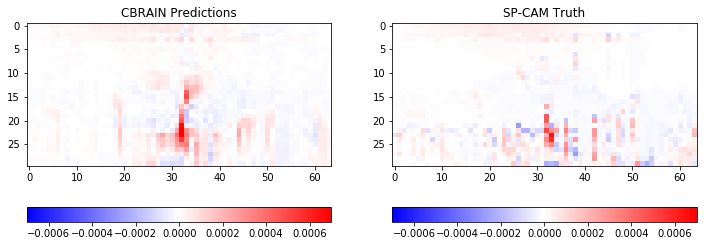

In [82]:
evaluate(mbn)

### Convolution

In [100]:
@threadsafe_generator
def data_generator_convo(data_dir, feature_fn, target_fn, shuffle=True,
                         batch_size=512, feature_norms=None, target_norms=None, noise=None):
    """Works on pre-stacked targets with truely random batches
    Hard coded right now for
    features = [TBP, QBP, VBP, PS, SOLIN, SHFLX, LHFLX]
    and lev = 30
    """
    # Open files
    feature_file = h5py.File(data_dir + feature_fn, 'r')
    target_file = h5py.File(data_dir + target_fn, 'r')

    # Determine sizes
    n_samples = feature_file['features'].shape[0]
    n_batches = int(np.floor(n_samples / batch_size))
    # Create ID list
    idxs = np.arange(0, n_samples, batch_size)
    if shuffle:
        np.random.shuffle(idxs)

    # generate
    while True:
        for i in range(n_batches):
            batch_idx = idxs[i]
            x = feature_file['features'][batch_idx:batch_idx + batch_size, :]
            if feature_norms is not None: x = (x - feature_norms[0]) / feature_norms[1]
            x1 = x[:, :90].reshape((x.shape[0], 30, -1))
            x2 = x[:, 90:]
            y = target_file['targets'][batch_idx:batch_idx + batch_size, :]
            if target_norms is not None: y = (y - target_norms[0]) * target_norms[1]
            if noise is not None:
                x += np.random.normal(0, noise, x.shape)
            yield [x1, x2], y

In [101]:
conv_gen = data_generator_convo(train_gen.data_dir, train_gen.feature_fn, train_gen.target_fn,
                                train_gen.shuffle, train_gen.batch_size, train_gen.feature_norms,
                                train_gen.target_norms, train_gen.noise)

In [6]:
mconv = conv_model((30, 3), 4, 65, [32, 64, 128], [256, 256], 1e-2, 'mse', activation='LeakyReLU', 
                   padding='valid', stride=2)

In [7]:
mconv.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 30, 3)        0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 14, 32)       320         input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu_9 (LeakyReLU)       (None, 14, 32)       0           conv1d_8[0][0]                   
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 6, 64)        6208        leaky_re_lu_9[0][0]              
__________________________________________________________________________________________________
leaky_re_l

In [104]:
mconv.fit_generator(
    conv_gen,
    train_gen.n_batches/5,
    epochs=3,
    workers=8,
    max_queue_size=50,
    callbacks=[LearningRateScheduler(get_lr_sched(1e-2, 5, 1))],
)

Epoch 1/3
lr: 0.002
4589/4588 [==============================] - 106s 23ms/step - loss: 0.0058 - rmse: 0.0563 - log_loss: -1.3903 - var_ratio: 0.5468 - mean_squared_error: 0.0058 - var_loss: 3.4098e-05
Epoch 2/3
lr: 0.0004000000000000001
4589/4588 [==============================] - 106s 23ms/step - loss: 0.0054 - rmse: 0.0535 - log_loss: -1.4186 - var_ratio: 0.5790 - mean_squared_error: 0.0054 - var_loss: 2.9325e-05
Epoch 3/3
lr: 8.000000000000002e-05
4589/4588 [==============================] - 106s 23ms/step - loss: 0.0053 - rmse: 0.0529 - log_loss: -1.4254 - var_ratio: 0.5849 - mean_squared_error: 0.0053 - var_loss: 2.8433e-05s - los


100%|██████████| 2868/2868 [02:02<00:00, 23.50it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:254: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:260: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
  1%|          | 3/287 [00:00<00:12, 23.63it/s]

TPHYSTND    0.501685
PHQ         0.471616
FSNT        0.989532
FSNS        0.978026
FLNT         0.89494
FLNS        0.817761
PRECT       0.865906
all         0.788495
Name: hor_r2, dtype: object


100%|██████████| 287/287 [00:12<00:00, 23.60it/s]


TPHYSTND    -1.17697
PHQ        -0.466722
FSNT        0.949916
FSNS        0.907665
FLNT        -1.79407
FLNS        0.668433
PRECT       -1.30942
all        -0.317311
Name: hor_r2, dtype: object


(<cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e148f20f0>,
 <cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e16635860>)

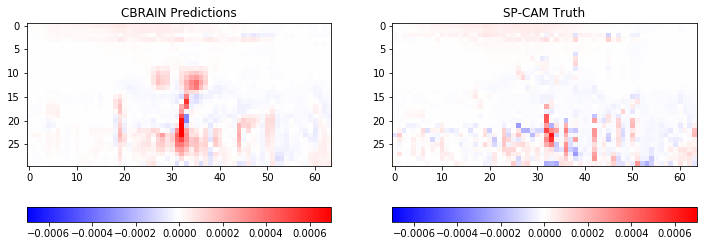

In [112]:
evaluate(mconv, convo=True)

### Convolution with batch norm

In [114]:
mconvbn = conv_model((30, 3), 4, 65, [16, 32], [256, 256], 1e-2, 'mse', activation='LeakyReLU', batch_norm=True)

In [115]:
mconvbn.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 30, 3)        0                                            
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 30, 16)       160         input_20[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_94 (LeakyReLU)      (None, 30, 16)       0           conv1d_11[0][0]                  
__________________________________________________________________________________________________
batch_normalization_15 (BatchNo (None, 30, 16)       64          leaky_re_lu_94[0][0]             
__________________________________________________________________________________________________
conv1d_12 

In [116]:
mconvbn.fit_generator(
    conv_gen,
    train_gen.n_batches/5,
    epochs=3,
    workers=8,
    max_queue_size=50,
    callbacks=[LearningRateScheduler(get_lr_sched(1e-2, 5, 1))],
)

Epoch 1/3
lr: 0.002
4589/4588 [==============================] - 248s 54ms/step - loss: 0.0082 - rmse: 0.0676 - log_loss: -1.2794 - var_ratio: 0.6148 - mean_squared_error: 0.0082 - var_loss: 7.9615e-04
Epoch 2/3
lr: 0.0004000000000000001
4589/4588 [==============================] - 226s 49ms/step - loss: 0.0059 - rmse: 0.0576 - log_loss: -1.3688 - var_ratio: 0.5494 - mean_squared_error: 0.0059 - var_loss: 3.3759e-05
Epoch 3/3
lr: 8.000000000000002e-05
4589/4588 [==============================] - 198s 43ms/step - loss: 0.0057 - rmse: 0.0561 - log_loss: -1.3867 - var_ratio: 0.5562 - mean_squared_error: 0.0057 - var_loss: 3.2716e-05


100%|██████████| 2868/2868 [02:34<00:00, 18.61it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:254: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:260: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
  1%|          | 2/287 [00:00<00:15, 18.91it/s]

TPHYSTND    0.400366
PHQ         -3.21357
FSNT        0.982916
FSNS        0.965291
FLNT        0.841959
FLNS         0.74294
PRECT       0.837101
all          0.22243
Name: hor_r2, dtype: object


100%|██████████| 287/287 [00:15<00:00, 18.69it/s]


TPHYSTND    -1.77104
PHQ         -1.18116
FSNT        0.929489
FSNS        0.869261
FLNT        -1.77123
FLNS        0.520032
PRECT       -1.13664
all        -0.505898
Name: hor_r2, dtype: object


(<cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e06b2cbe0>,
 <cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e122f1ba8>)

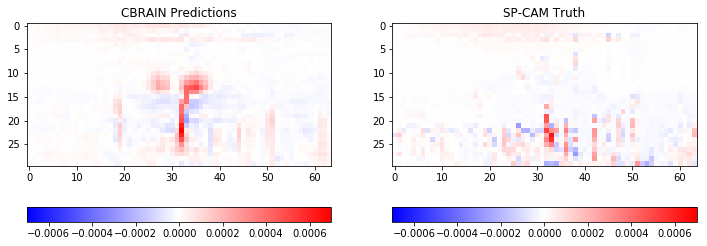

In [117]:
evaluate(mconvbn, convo=True)

### Convolution with tiles

In [118]:
@threadsafe_generator
def data_generator_convo_tile(data_dir, feature_fn, target_fn, shuffle=True,
                              batch_size=512, feature_norms=None, target_norms=None, noise=None):
    """Works on pre-stacked targets with truely random batches
    Hard coded right now for
    features = [TBP, QBP, VBP, PS, SOLIN, SHFLX, LHFLX]
    and lev = 30
    """
    # Open files
    feature_file = h5py.File(data_dir + feature_fn, 'r')
    target_file = h5py.File(data_dir + target_fn, 'r')

    # Determine sizes
    n_samples = feature_file['features'].shape[0]
    n_batches = int(np.floor(n_samples / batch_size))
    # Create ID list
    idxs = np.arange(0, n_samples, batch_size)
    if shuffle:
        np.random.shuffle(idxs)

    # generate
    while True:
        for i in range(n_batches):
            batch_idx = idxs[i]
            x = feature_file['features'][batch_idx:batch_idx + batch_size, :]
            if feature_norms is not None: x = (x - feature_norms[0]) / feature_norms[1]
            x = np.concatenate(
                [
                    x[:, :90].reshape((x.shape[0], 30, -1)),
                    np.rollaxis(np.tile(x[:, 90:], (30, 1, 1)), 0, 2)
                ],
                axis=-1,
            )
            y = target_file['targets'][batch_idx:batch_idx + batch_size, :]
            if target_norms is not None: y = (y - target_norms[0]) * target_norms[1]
            if noise is not None:
                x += np.random.normal(0, noise, x.shape)
            yield x, y

In [120]:
conv_gen_tile = data_generator_convo_tile(train_gen.data_dir, train_gen.feature_fn, train_gen.target_fn,
                                train_gen.shuffle, train_gen.batch_size, train_gen.feature_norms,
                                train_gen.target_norms, train_gen.noise)

In [137]:
mconvtile = conv_model((30, 7), None, 65, [16, 32, 64], [512], 1e-2, 'mse', activation='LeakyReLU', tile=True,
                       padding='valid', stride=2, dr=0.2)

In [138]:
mconvtile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 30, 7)             0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 14, 16)            352       
_________________________________________________________________
leaky_re_lu_119 (LeakyReLU)  (None, 14, 16)            0         
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 6, 32)             1568      
_________________________________________________________________
leaky_re_lu_120 (LeakyReLU)  (None, 6, 32)             0         
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 2, 64)             6208      
_________________________________________________________________
leaky_re_lu_121 (LeakyReLU)  (None, 2, 64)             0         
__________

In [139]:
mconvtile.fit_generator(
    conv_gen_tile,
    train_gen.n_batches/5,
    epochs=3,
    workers=8,
    max_queue_size=50,
    callbacks=[LearningRateScheduler(get_lr_sched(1e-2, 5, 1))],
)

Epoch 1/3
lr: 0.002
4589/4588 [==============================] - 107s 23ms/step - loss: 0.0063 - rmse: 0.0584 - log_loss: -1.3718 - var_ratio: 0.5143 - mean_squared_error: 0.0063 - var_loss: 3.9179e-05
Epoch 2/3
lr: 0.0004000000000000001
4589/4588 [==============================] - 101s 22ms/step - loss: 0.0058 - rmse: 0.0563 - log_loss: -1.3894 - var_ratio: 0.5444 - mean_squared_error: 0.0058 - var_loss: 3.4227e-05
Epoch 3/3
lr: 8.000000000000002e-05
4589/4588 [==============================] - 100s 22ms/step - loss: 0.0057 - rmse: 0.0559 - log_loss: -1.3926 - var_ratio: 0.5493 - mean_squared_error: 0.0057 - var_loss: 3.3523e-05


100%|██████████| 2868/2868 [03:10<00:00, 15.09it/s]
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:259: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_tvar'] = self.stats['hor_tsqmean'] - self.stats['hor_tmean'] ** 2
/data11/home/srasp/repositories/CBRAIN-CAM/notebooks/dev/cbrain/model_diagnostics.py:265: RuntimeWarning: divide by zero encountered in true_divide
  columns=list(self.stats.keys()))
  1%|▏         | 4/287 [00:00<00:08, 31.59it/s]

TPHYSTND    0.437976
PHQ         0.418522
FSNT        0.985722
FSNS        0.971067
FLNT        0.836912
FLNS        0.720822
PRECT       0.837944
all         0.744138
Name: hor_r2, dtype: object


100%|██████████| 287/287 [00:17<00:00, 16.07it/s]


TPHYSTND   -0.913182
PHQ        -0.311396
FSNT        0.943469
FSNS        0.895382
FLNT        -1.97881
FLNS        0.533248
PRECT      -0.901242
all        -0.247504
Name: hor_r2, dtype: object


(<cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e273229e8>,
 <cbrain.model_diagnostics.ModelDiagnostics at 0x2b0e24b3b518>)

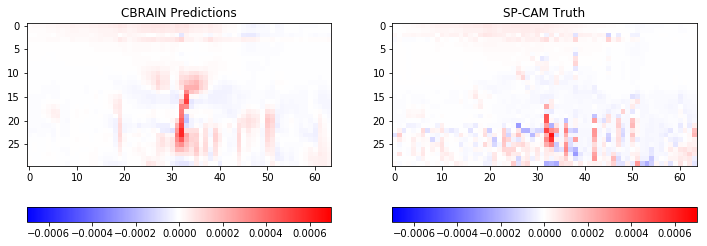

In [143]:
evaluate(mconvtile, convo_tile=True)

### Dropout

### L2 Regularization

### Input noise